In [1]:
import torch
import torch.nn as nn
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
import numpy as np
import torch.nn.functional as F
import pickle
from data import *
from util import *
from model import *
from loss_functions import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using {}".format(device))

Using cpu


In [2]:
#train set
data = np.load("train_10000_bfs_k5_N20.npz")
X_loaded = torch.Tensor(data["X"]).to(device) #shape N, 20, 2 N = 10000
tri_loaded = torch.Tensor(data["tri"]).to(device)

train_dataset = GraphDataSet_new(X_loaded, tri_loaded)
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#test set
data_test = np.load("test_5000_bfs_k5_N20.npz")
X_test = torch.Tensor(data_test["X"]).to(device) #shape N, 20, 2 N = 10000
tri_test = torch.Tensor(data_test["tri"]).to(device)

test_dataset = GraphDataSet_new(X_test, tri_test)
batch_size = 256
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [3]:
##structure for the MPGNN Pointer network
class EdgeNetwork(nn.Module):
    '''
    The MLP that takes starting vertex and ending vertex and the edge embedding
    and compute the message Phi(x_i, x_j, e_ij)
    '''
    def __init__(self, input_dim, hidden_dim, message_dim):
        '''
        Args:
            input_dim: the dimension of input: len(x_i) + len(x_j) + len(e_ij)
            hidden_dim: hidden dimension
            messgage_dim: the dimension of the message vector 
        '''
        super().__init__()
        self.edge_mlp = Seq(
            Lin(input_dim, hidden_dim),
            ReLU(),
            Lin(hidden_dim, message_dim)
        )

    def forward(self, edge_attr, x_i, x_j):
        out = torch.cat([x_i, x_j, edge_attr], dim=1)
        return self.edge_mlp(out)
    

class MPNNWithEdgeUpdate(MessagePassing):
    '''
    One layer of message passing: gamma (x_i, agg(Phi(x_i, x_j, e_ij)))
    '''
    def __init__(self, node_dim, edge_dim, hidden_dim, message_dim, new_node_dim, new_edge_dim, initial=False):
        super().__init__(aggr='add')  # sum aggregation
        
        #the neural network Phi to create the message from xi, xj and eij
        self.message_mlp = EdgeNetwork(new_edge_dim + 2 * node_dim, hidden_dim, message_dim)


        #the network to update node embedding 
        self.node_update = Seq(
            Lin(node_dim + message_dim, hidden_dim),
            ReLU(),
            Lin(hidden_dim, new_node_dim)
        )

        #the network to update edge embedding
        self.edge_network = EdgeNetwork(edge_dim + 2 * node_dim, hidden_dim, new_edge_dim)

    def forward(self, batched_data):
        '''
        forward function of one layer of message passing 

        Args:
            batched_data: pyg batched data type must contains the following attributes
                x: [B*N, node_dim] the embeddings of all the vertices in one batch
                edge_attr: [num_edges, edge_dim] the embeddings of all edges in one batch
                edge_index: [2, B*N] indices of connected edges in the batched graph

        Returns:
            node_embeddings: [B*N, new_node_embedding_dim] embeddings of all nodes in new embedding dimension
            edge_embeddings: [num_edges, new_edge_embedding_dim] embeddings of all edges in new edge embedding dimension

        '''
        # x: [num_nodes, node_dim]
        # edge_attr: [num_edges, edge_dim]
        x = batched_data.x; edge_index =batched_data.edge_index; edge_attr = batched_data.edge_attr
        
        return self.propagate(edge_index, x=x, edge_attr=edge_attr), self.updated_edge_attr

    def message(self, x_i, x_j, edge_attr):
        # Compute edge-updated features first 
        updated_edge_attr = self.edge_network(edge_attr, x_i, x_j)
        self.updated_edge_attr = updated_edge_attr
        #msg_input = torch.cat([x_i, x_j, updated_edge_attr], dim=1)
        return self.message_mlp(updated_edge_attr, x_i, x_j)

    def update(self, aggr_out, x):
        node_input = torch.cat([x, aggr_out], dim=1)
        return self.node_update(node_input)

class MP_GNN(nn.Module):
    '''
    This is the message passing graph neural network that contains several message passing layers
    '''
    def __init__(self, initial_node_dim, initial_edge_dim, embedding_dim, num_layers):
        super().__init__()
        self.num_layers = num_layers
        self.initial_layer = MPNNWithEdgeUpdate(initial_node_dim, initial_edge_dim, 
                                                embedding_dim, embedding_dim, embedding_dim, embedding_dim)

        self.layers_list = nn.ModuleList()
        for _ in range(num_layers-1):
            self.layers_list.append(MPNNWithEdgeUpdate(embedding_dim, embedding_dim, 
                                                embedding_dim, embedding_dim, embedding_dim, embedding_dim))

    def forward(self, batched_data):
        ##add the self adge first
        edge_index, edge_attr = add_self_loops(batched_data.edge_index, edge_attr=batched_data.edge_attr, fill_value=0.0, 
                                               num_nodes=batched_data.x.size(0))
        batched_data.edge_index = edge_index; batched_data.edge_attr = edge_attr
        
        #goes through the first layer
        x, edge_attr = self.initial_layer(batched_data)
        batched_data.x = x; batched_data.edge_attr = edge_attr
        #goes through all the remianin layers
        for layer in self.layers_list:
            x, edge_attr = layer(batched_data)
            batched_data.x = x; batched_data.edge_attr = edge_attr
        return x, edge_attr


class EncoderLSTM(nn.Module):
    """
    LSTM Encoder:
      - input:  (batch_size, seq_len, input_dim)
      - output: (batch_size, seq_len, hidden_dim) + (h, c) final states
    """
    def __init__(self, input_dim, hidden_dim, num_layers=1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False
        )
        
    def forward(self, x):
        """
        Args:
          x: (batch_size, seq_len, input_dim)
        Returns:
          encoder_outputs: (batch_size, seq_len, hidden_dim)
          (h, c): final hidden, cell states
        """
        encoder_outputs, (h, c) = self.lstm(x)  # h,c shape: (num_layers, batch, hidden_dim)
        return encoder_outputs, (h, c)

class DecoderLSTM(nn.Module):
    """
    LSTM Decoder:
      - We run for multiple steps (each step can produce one triangle).
      - Input size = 3 * hidden_dim (since we feed a concatenation of 3 node embeddings).
      - On each step, we produce a pointer distribution over (N+1) "nodes":
        the real N nodes + 1 "end token" node.
    """
    def __init__(self, hidden_dim, num_layers=1):
        super().__init__()
        self.hidden_dim = hidden_dim
        
        # LSTMCell expects input_size = 3*hidden_dim (concatenation of 3 node embeddings)
        self.input_size = 3 * hidden_dim
        self.lstm_cell = nn.LSTMCell(self.input_size, hidden_dim)
        
        # A transform for the pointer "query" if desired
        self.query_transform = nn.Linear(hidden_dim, hidden_dim)

    def forward(self,
                encoder_outputs,
                hidden,
                cell,
                end_node_embed,
                initial_input,
                max_steps=10, 
                teacher_indices=None):
        """
        Args:
          encoder_outputs: (batch_size, N, hidden_dim)
            - includes real node embeddings for the first N-1 positions
            - the last position is the "end token" embedding
          hidden, cell: initial hidden/cell states for the decoder
          end_node_embed: (1, hidden_dim) - if you need it separately for something
          initial_input: (batch_size, 3*hidden_dim) start token embedding
          max_steps: the maximum number of triangles to decode
          teacher_indices: shape (batch_size, max_steps, 3), or None
              if None, Prediction mode
              if not None, train mode, where the input will be truth triangles
          
        Returns:
          pointer_logits_list: tensor of shape (max_steps, B, N+1)
          chosen_indices_list: tensor of shape (max_steps, B, 3)
        """
        batch_size, N, hd = encoder_outputs.shape
        
        pointer_logits_list = []
        chosen_indices_list = []

        # We'll use the given initial_input for step 0
        # for later step, it will be either from teacher enforcing or from the model's own prediction 
        input_t = initial_input  # shape (batch_size, 3*hidden_dim)

        #pad the teacher_indices if len < max_steps
        if teacher_indices is not None and teacher_indices.shape[1] < max_steps:
            teacher_indices = F.pad(teacher_indices, (0, 0, 0, max_steps-teacher_indices.shape[1]), value=-1).to(torch.int)

        for t in range(max_steps):
            # LSTMCell step
            hidden, cell = self.lstm_cell(input_t, (hidden, cell))

            # Pointer distribution
            query = self.query_transform(hidden)   # (batch_size, hidden_dim)
            query_expanded = query.unsqueeze(1).expand(-1, N, -1)  # (batch_size, N, hidden_dim)
            pointer_logits = torch.sum(query_expanded * encoder_outputs, dim=-1)  # (batch_size, N)
            pointer_logits_list.append(pointer_logits)

            _, top3_indices = torch.topk(pointer_logits, k=3, dim=1)  # (batch_size, 3)

            # Pick top-3 from pointer logits or from teacher enforcing solution 
            if teacher_indices is None:
                next_indices = top3_indices
            else:
                ##teacher forcing mode, use ground truth 
                next_indices = teacher_indices[:, t, :].to(torch.int64)  # shape (batch_size, 3)
                next_indices[next_indices == -1] = 0 # replace -1 with 0 because gather does not accept -1
                

            chosen_indices_list.append(top3_indices)

            # Build the next input by concatenating the chosen embeddings
            top3_vectors = torch.gather(
                encoder_outputs,  # (batch_size, N, hidden_dim)
                dim=1,
                index=next_indices.unsqueeze(-1).expand(-1, -1, hd)
            )
            # shape of top3_vectors: (batch_size, 3, hidden_dim)
            input_t = top3_vectors.view(batch_size, 3 * hd)  # (batch_size, 3*hidden_dim)

        return torch.stack(pointer_logits_list), torch.stack(chosen_indices_list)

class DecoderLSTM_att(nn.Module):
    """
    Decoder with causal self-attention.
    • identical public API to DecoderLSTM
    • after each LSTMCell step, the current hidden state attends over
      all previous decoder hidden states (including itself)
    """
    def __init__(self, hidden_dim, num_layers=1, num_heads=4, dropout=0.0, num_cold_start=0):
        """
        Args
        ----
        hidden_dim : int   - dimension of LSTM hidden state
        num_layers : int   - # layers in LSTMCell stack  (kept for parity)
        num_heads  : int   - heads in MultiheadAttention
        dropout    : float - dropout inside attention
        """
        super().__init__()
        self.hidden_dim = hidden_dim
        self.input_size = 3 * hidden_dim

        self.lstm_cell = nn.LSTMCell(self.input_size, hidden_dim)
        self.num_cold_start = num_cold_start

        # multi‑head self‑attention; batch_first=True gives shape (B, S, D)
        self.self_attn = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )

        self.query_transform = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, encoder_outputs, hidden, cell,
                end_node_embed, initial_input,
                max_steps=10, teacher_indices=None):

        batch_size, N, hd = encoder_outputs.shape
        pointer_logits_list, chosen_indices_list = [], []
        input_t = initial_input
        saved_hiddens = []                         # ← list of *copies*

        if teacher_indices is not None and teacher_indices.shape[1] < max_steps:
            teacher_indices = F.pad(teacher_indices,
                                    pad=(0, 0, 0, max_steps - teacher_indices.shape[1]),
                                    value=-1).to(torch.int64)
                                    

        for _ in range(self.num_cold_start):
            # LSTM step
            hidden, cell = self.lstm_cell(input_t, (hidden, cell))

            # causal self‑attention over past dec‑states
            saved_hiddens.append(hidden.clone())
            kv = torch.stack(saved_hiddens, dim=1)       # (B, s, hd)
            q  = hidden.unsqueeze(1)                    # (B, 1, hd)
            attn_out, _ = self.self_attn(q, kv, kv, need_weights=False)
            hidden_ctx = 0.5 * (hidden + attn_out.squeeze(1))

            # pointer distribution
            query = self.query_transform(hidden_ctx)
            pointer_logits = torch.sum(
                query.unsqueeze(1) * encoder_outputs, dim=-1
            )                                           # (B, N)
            #pointer_logits_list.append(pointer_logits)

            # choose next indices (top‑3, sorted) and build next input
            _, pred_idx = torch.topk(pointer_logits, k=3, dim=1)
            pred_idx, _ = torch.sort(pred_idx, dim=1)
            #chosen_indices_list.append(pred_idx)

            top3_vec = torch.gather(
                encoder_outputs,
                1,
                pred_idx.unsqueeze(-1).expand(-1, -1, hd)
            )                                           # (B, 3, hd)
            input_t = top3_vec.reshape(batch_size, 3 * hd)



        for t in range(max_steps):
            # 1) LSTM step
            hidden, cell = self.lstm_cell(input_t, (hidden, cell))   # (B, hd)

            # 2) save a copy for causal self‑attention
            saved_hiddens.append(hidden.clone())                     #   changed

            kv = torch.stack(saved_hiddens, dim=1)                   # (B, t+1, hd)
            q  = hidden.unsqueeze(1)                                 # (B, 1,  hd)
            attn_out, _ = self.self_attn(q, kv, kv, need_weights=False)
            attn_out = attn_out.squeeze(1)
            hidden_ctx = 0.5 * (hidden + attn_out)                   # residual

            # 3) pointer distribution
            query = self.query_transform(hidden_ctx)
            # print("Query shape: ", query.shape)
            # print("Encoder outputs shape: ", encoder_outputs.shape)
            # print()
            pointer_logits = torch.sum(
                query.unsqueeze(1) * encoder_outputs, dim=-1)
            pointer_logits_list.append(pointer_logits)

            _, top3_pred = torch.topk(pointer_logits, k=3, dim=1)
            #sort the indices
            top3_pred, _ = torch.sort(top3_pred, dim=1)

            # 4) teacher forcing
            if teacher_indices is None:
                next_indices = top3_pred
            else:
                next_indices = teacher_indices[:, t, :].to(torch.int64)
                next_indices = torch.where(next_indices == -1,
                                           torch.zeros_like(next_indices),
                                           next_indices)

            chosen_indices_list.append(top3_pred)

            # 5) build next input
            top3_vec = torch.gather(
                encoder_outputs,
                1,
                next_indices.unsqueeze(-1).expand(-1, -1, hd)
            )                                       # (B, 3, hd)
            input_t = top3_vec.reshape(batch_size, 3 * hd)

        return (torch.stack(pointer_logits_list),
                torch.stack(chosen_indices_list))

class PointerNetForTriangles(nn.Module):
    """
    Full Pointer Network that:
      - Has an LSTM encoder
      - Adds a "virtual end-node embedding" to the encoder outputs
      - Has a learnable "start token" embedding for the decoder's first input
      - Decodes up to max_steps, each step producing a triple of node indices
    """
    def __init__(self, input_dim, hidden_dim, num_layers=1, max_steps=10, attention=False, num_cold_start=0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.max_steps = max_steps
        
        # Encoder
        self.encoder = EncoderLSTM(input_dim, hidden_dim, num_layers)
        
        # A learnable parameter to serve as "end node"
        self.end_node_embed = nn.Parameter(torch.randn(1, hidden_dim))
        
        # A learnable "start token" that the decoder sees at time t=0
        # Because we feed 3*hidden_dim each step, define it that shape:
        self.start_token_embed = nn.Parameter(torch.randn(1, 3 * hidden_dim))
        
        # Decoder
        if not attention:
            self.decoder = DecoderLSTM(hidden_dim, num_layers)
        else:
            self.decoder = DecoderLSTM_att(hidden_dim, num_layers, num_cold_start=num_cold_start)

    def forward(self, x, teacher_indices=None, max_steps=40):
        """
        x: (batch_size, seq_len, input_dim) -- real node inputs
        Returns:
          pointer_logits_list: list of (batch_size, N)
          chosen_indices_list: list of (batch_size, 3)
        """
        batch_size, seq_len, _ = x.shape
        
        # 1) Encode
        encoder_outputs, (h_enc, c_enc) = self.encoder(x)
        # h_enc, c_enc: shape (num_layers, batch, hidden_dim)
        
        # We'll only take the top layer hidden/cell if num_layers > 1
        h_enc = h_enc[-1]  # (batch, hidden_dim)
        c_enc = c_enc[-1]  # (batch, hidden_dim)
        
        # 2) Append "end node" to encoder_outputs
        end_node_tiled = self.end_node_embed.unsqueeze(0).expand(batch_size, -1, -1)
        encoder_outputs = torch.cat([encoder_outputs, end_node_tiled], dim=1)
        # Now encoder_outputs has shape (batch, N, hidden_dim)
        # N = seq_len + 1  (the extra one is the end node)
        
        # 3) Prepare the decoder's initial input from the start token
        start_tiled = self.start_token_embed.expand(batch_size, -1)  # (batch_size, 3*hidden_dim)
        
        # 4) Run the decoder
        pointer_logits_list, chosen_indices_list = self.decoder(
            encoder_outputs,
            h_enc,
            c_enc,
            end_node_embed=self.end_node_embed,
            initial_input=start_tiled,
            max_steps=max(self.max_steps, max_steps), 
            teacher_indices = teacher_indices
        )
        
        return pointer_logits_list, chosen_indices_list

class GraphPointerNet(nn.Module):
    '''
    This is the funal node that consists of 1. Message Passing GNN 2. A LSTM as Pointer Network
    '''
    
    def __init__(self, initial_node_dim, initial_edge_dim, embedding_dim = 32, num_layers=4, num_layers_LSTM = 1,
                 hidden_dim=64, max_steps=40, attention=False, num_cold_start=0):
        '''
        Arguments:
            initial_node_dim: the initial node dim before anything, usually 2, the 2d coordinate
            initial_edge_dim: the initial edge dimension before anything, usually 4
            embedding_dim: the embedding dimension for both the node and edge in MSP GNN
            num_layers: number of layers in the message passing GNN
            hidden_dim: the hidden dimension in the LSTM, in encoder hidden state has len hidden_dim, in decoder, 
                the hidden state has shape 3*hidden_dim and takes input of shape 3*hidden_dim
            max_steps: number of steps made in the decoder, in this implementation, the model will always make
                max_steps predictions even if the end of sequence token is predicted

        '''
        super().__init__()
        self.max_steps = max_steps
        self.MP_model = MP_GNN(initial_node_dim, initial_edge_dim, embedding_dim, num_layers)
        self.Pointer_model = PointerNetForTriangles(embedding_dim, hidden_dim, max_steps=max_steps, 
                attention=attention, num_layers=num_layers_LSTM, num_cold_start=num_cold_start)
        self.embedding_dim = embedding_dim

    def forward(self, data_batch, teacher_indices=None, N=20, max_steps=40):
        '''
        Arguments:
            data_batch: a pyg data set that contains the following attributes:
                x: [B*N_nodes, initial_dim], the initial embeddings of all nodes in one batch
                edge_index: [2, (k * N_nodes * B)*2], indice pairs of directed edges in the batched graph
                edge_attr: [(k * N_nodes * B)*2, initial_edge_dim], initial edge embeddings of all the edges in the batched graph 

        '''
        
        node_embeddings, edge_embeddings = self.MP_model(data_batch)
        #reshape the node embeddings into shape (B, N, embedding_dim)
        node_embeddings = node_embeddings.reshape(-1, N, self.embedding_dim)
        logits, indices = self.Pointer_model(node_embeddings, teacher_indices=teacher_indices, max_steps=max(max_steps, self.max_steps))

        return logits, indices

In [4]:
##train 
learning_rate = 1e-3
model = GraphPointerNet(2, 4, embedding_dim = 32, num_layers=5, 
                        num_layers_LSTM = 1, hidden_dim=256, max_steps=40, attention=True, num_cold_start=0).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
              optimizer, mode='min', factor=0.5, patience=2000, verbose=False)

loss_trace = []
iou = []
epochs = 200
k = 5

for i in tqdm(range(epochs)):
    #pass through all the data
    for x, tri in tqdm(train_loader):
        #prepare the data batch
        data_batch = make_pyg_batch_wedge(x, k)
        
        #forward pass
        logits, indicies = model(data_batch, teacher_indices=tri)
        
        #compute the loss
        loss = loss_neg_log(logits, tri)
        
        #backward pass and optimization 
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # grad‑clip
        optimizer.step()
        scheduler.step(loss.item())
        
        loss_trace.append(loss.item())
        iou.append(iou_triangles(tri, indicies))

    print("Epoch {}, loss: {:.4f}, iou: {:.4f}".format(i+1, loss_trace[-1], iou[-1]))

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 1, loss: 2.4356, iou: 0.1036


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 2, loss: 2.2458, iou: 0.1359


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 3, loss: 1.9693, iou: 0.2489


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 4, loss: 1.9364, iou: 0.2898


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 5, loss: 1.8334, iou: 0.3203


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 6, loss: 1.7737, iou: 0.3582


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 7, loss: 1.7376, iou: 0.3779


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 8, loss: 1.6613, iou: 0.4367


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 9, loss: 1.6419, iou: 0.4589


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 10, loss: 1.6126, iou: 0.4654


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 11, loss: 1.5768, iou: 0.4999


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 12, loss: 1.5488, iou: 0.5298


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 13, loss: 1.5547, iou: 0.5218


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 14, loss: 1.5344, iou: 0.5393


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 15, loss: 1.5474, iou: 0.5311


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 16, loss: 1.5150, iou: 0.5530


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 17, loss: 1.5075, iou: 0.5694


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 18, loss: 1.4937, iou: 0.5848


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 19, loss: 1.4835, iou: 0.5910


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 20, loss: 1.4841, iou: 0.5909


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 21, loss: 1.4652, iou: 0.5996


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 22, loss: 1.4509, iou: 0.6136


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 23, loss: 1.4436, iou: 0.6184


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 24, loss: 1.4584, iou: 0.6085


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 25, loss: 1.4416, iou: 0.6285


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 26, loss: 1.4255, iou: 0.6374


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 27, loss: 1.4219, iou: 0.6408


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 28, loss: 1.4202, iou: 0.6424


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 29, loss: 1.4141, iou: 0.6601


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 30, loss: 1.4119, iou: 0.6553


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 31, loss: 1.4091, iou: 0.6508


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 32, loss: 1.3981, iou: 0.6592


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 33, loss: 1.3980, iou: 0.6685


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 34, loss: 1.3939, iou: 0.6661


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 35, loss: 1.3840, iou: 0.6825


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 36, loss: 1.3846, iou: 0.6787


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 37, loss: 1.3885, iou: 0.6814


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 38, loss: 1.3741, iou: 0.6816


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 39, loss: 1.3791, iou: 0.6978


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 40, loss: 1.3697, iou: 0.6965


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 41, loss: 1.3687, iou: 0.7033


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 42, loss: 1.3671, iou: 0.7094


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 43, loss: 1.3651, iou: 0.7029


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 44, loss: 1.3560, iou: 0.7104


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 45, loss: 1.3592, iou: 0.7041


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 46, loss: 1.3534, iou: 0.7211


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 47, loss: 1.3542, iou: 0.7208


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 48, loss: 1.3507, iou: 0.7145


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 49, loss: 1.3464, iou: 0.7199


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 50, loss: 1.3569, iou: 0.7106


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 51, loss: 1.3568, iou: 0.7137


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 52, loss: 1.3407, iou: 0.7244


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 53, loss: 1.3498, iou: 0.7189


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 54, loss: 1.3454, iou: 0.7326


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 55, loss: 1.3434, iou: 0.7211


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 56, loss: 1.3318, iou: 0.7452


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 57, loss: 1.3479, iou: 0.7187


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 58, loss: 1.3447, iou: 0.7276


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 59, loss: 1.3327, iou: 0.7271


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 60, loss: 1.3212, iou: 0.7458


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 61, loss: 1.3306, iou: 0.7303


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 62, loss: 1.3385, iou: 0.7288


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 63, loss: 1.3302, iou: 0.7440


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 64, loss: 1.3291, iou: 0.7442


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 65, loss: 1.3365, iou: 0.7349


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 66, loss: 1.3212, iou: 0.7319


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 67, loss: 1.3340, iou: 0.7292


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 68, loss: 1.3185, iou: 0.7492


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 69, loss: 1.3233, iou: 0.7479


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 70, loss: 1.3260, iou: 0.7465


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 71, loss: 1.3140, iou: 0.7526


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 72, loss: 1.3266, iou: 0.7472


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 73, loss: 1.3158, iou: 0.7519


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 74, loss: 1.3119, iou: 0.7609


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 75, loss: 1.3080, iou: 0.7608


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 76, loss: 1.3115, iou: 0.7619


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 77, loss: 1.3050, iou: 0.7686


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 78, loss: 1.3094, iou: 0.7643


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 79, loss: 1.3016, iou: 0.7678


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 80, loss: 1.3002, iou: 0.7678


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 81, loss: 1.3040, iou: 0.7702


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 82, loss: 1.3114, iou: 0.7567


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 83, loss: 1.3058, iou: 0.7661


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 84, loss: 1.3142, iou: 0.7624


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 85, loss: 1.2981, iou: 0.7722


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 86, loss: 1.3098, iou: 0.7563


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 87, loss: 1.2974, iou: 0.7753


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 88, loss: 1.3007, iou: 0.7760


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 89, loss: 1.3022, iou: 0.7769


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 90, loss: 1.2984, iou: 0.7662


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 91, loss: 1.2999, iou: 0.7757


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 92, loss: 1.2975, iou: 0.7786


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 93, loss: 1.2930, iou: 0.7700


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 94, loss: 1.2943, iou: 0.7783


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 95, loss: 1.2876, iou: 0.7835


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 96, loss: 1.2946, iou: 0.7798


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 97, loss: 1.2894, iou: 0.7824


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 98, loss: 1.2915, iou: 0.7813


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 99, loss: 1.2872, iou: 0.7901


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 100, loss: 1.2899, iou: 0.7836


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 101, loss: 1.3004, iou: 0.7680


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 102, loss: 1.3006, iou: 0.7732


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 103, loss: 1.2823, iou: 0.7885


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 104, loss: 1.2783, iou: 0.7967


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 105, loss: 1.2868, iou: 0.7912


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 106, loss: 1.2820, iou: 0.7937


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 107, loss: 1.2918, iou: 0.7847


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 108, loss: 1.2925, iou: 0.7732


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 109, loss: 1.2820, iou: 0.7884


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 110, loss: 1.2887, iou: 0.7790


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 111, loss: 1.2883, iou: 0.7922


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 112, loss: 1.2855, iou: 0.7841


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 113, loss: 1.2884, iou: 0.7956


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 114, loss: 1.2812, iou: 0.7923


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 115, loss: 1.2817, iou: 0.7971


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 116, loss: 1.2738, iou: 0.7979


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 117, loss: 1.2794, iou: 0.7958


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 118, loss: 1.2790, iou: 0.7940


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 119, loss: 1.2902, iou: 0.7833


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 120, loss: 1.2773, iou: 0.8029


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 121, loss: 1.2797, iou: 0.7968


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 122, loss: 1.2804, iou: 0.7988


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 123, loss: 1.2702, iou: 0.8001


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 124, loss: 1.2741, iou: 0.8068


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 125, loss: 1.2820, iou: 0.7981


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 126, loss: 1.2777, iou: 0.7934


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 127, loss: 1.2805, iou: 0.7931


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 128, loss: 1.2662, iou: 0.8132


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 129, loss: 1.2673, iou: 0.8064


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 130, loss: 1.2719, iou: 0.8029


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 131, loss: 1.2729, iou: 0.8005


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 132, loss: 1.2776, iou: 0.8040


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 133, loss: 1.2697, iou: 0.8072


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 134, loss: 1.2778, iou: 0.8008


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 135, loss: 1.2673, iou: 0.8122


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 136, loss: 1.2675, iou: 0.8112


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 137, loss: 1.2767, iou: 0.8077


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 138, loss: 1.2708, iou: 0.8031


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 139, loss: 1.2744, iou: 0.7971


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 140, loss: 1.2677, iou: 0.8093


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 141, loss: 1.2631, iou: 0.8192


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 142, loss: 1.2625, iou: 0.8195


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 143, loss: 1.2700, iou: 0.8070


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 144, loss: 1.2643, iou: 0.8115


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 145, loss: 1.2686, iou: 0.8031


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 146, loss: 1.2687, iou: 0.8099


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 147, loss: 1.2657, iou: 0.8111


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 148, loss: 1.2632, iou: 0.8174


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 149, loss: 1.2646, iou: 0.8148


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 150, loss: 1.2650, iou: 0.8194


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 151, loss: 1.2635, iou: 0.8114


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 152, loss: 1.2697, iou: 0.8147


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 153, loss: 1.2639, iou: 0.8196


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 154, loss: 1.2602, iou: 0.8151


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 155, loss: 1.2644, iou: 0.8227


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 156, loss: 1.2580, iou: 0.8192


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 157, loss: 1.2592, iou: 0.8268


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 158, loss: 1.2722, iou: 0.8095


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 159, loss: 1.2625, iou: 0.8179


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 160, loss: 1.2435, iou: 0.8429


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 161, loss: 1.2333, iou: 0.8493


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 162, loss: 1.2376, iou: 0.8498


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 163, loss: 1.2395, iou: 0.8378


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 164, loss: 1.2413, iou: 0.8414


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 165, loss: 1.2346, iou: 0.8533


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 166, loss: 1.2415, iou: 0.8456


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 167, loss: 1.2389, iou: 0.8419


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 168, loss: 1.2321, iou: 0.8544


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 169, loss: 1.2336, iou: 0.8556


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 170, loss: 1.2389, iou: 0.8411


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 171, loss: 1.2346, iou: 0.8551


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 172, loss: 1.2342, iou: 0.8546


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 173, loss: 1.2352, iou: 0.8611


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 174, loss: 1.2322, iou: 0.8523


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 175, loss: 1.2253, iou: 0.8616


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 176, loss: 1.2328, iou: 0.8481


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 177, loss: 1.2298, iou: 0.8565


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 178, loss: 1.2284, iou: 0.8602


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 179, loss: 1.2343, iou: 0.8473


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 180, loss: 1.2383, iou: 0.8498


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 181, loss: 1.2335, iou: 0.8533


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 182, loss: 1.2329, iou: 0.8550


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 183, loss: 1.2281, iou: 0.8665


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 184, loss: 1.2373, iou: 0.8549


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 185, loss: 1.2306, iou: 0.8580


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 186, loss: 1.2298, iou: 0.8586


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 187, loss: 1.2306, iou: 0.8603


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 188, loss: 1.2306, iou: 0.8523


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 189, loss: 1.2266, iou: 0.8600


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 190, loss: 1.2301, iou: 0.8605


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 191, loss: 1.2303, iou: 0.8591


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 192, loss: 1.2367, iou: 0.8532


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 193, loss: 1.2338, iou: 0.8587


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 194, loss: 1.2232, iou: 0.8679


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 195, loss: 1.2244, iou: 0.8724


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 196, loss: 1.2256, iou: 0.8714


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 197, loss: 1.2249, iou: 0.8670


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 198, loss: 1.2272, iou: 0.8636


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 199, loss: 1.2279, iou: 0.8638


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 200, loss: 1.2247, iou: 0.8741


In [5]:
model

GraphPointerNet(
  (MP_model): MP_GNN(
    (initial_layer): MPNNWithEdgeUpdate()
    (layers_list): ModuleList(
      (0-3): 4 x MPNNWithEdgeUpdate()
    )
  )
  (Pointer_model): PointerNetForTriangles(
    (encoder): EncoderLSTM(
      (lstm): LSTM(32, 256, batch_first=True)
    )
    (decoder): DecoderLSTM_att(
      (lstm_cell): LSTMCell(768, 256)
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (query_transform): Linear(in_features=256, out_features=256, bias=True)
    )
  )
)

In [4]:
##load some model
model = GraphPointerNet(2, 4, embedding_dim = 32, num_layers=5, 
                        num_layers_LSTM = 1, hidden_dim=256, max_steps=40, attention=True, num_cold_start=0).to(device)
# Load the state dictionary from the file
state_dict = torch.load("model18.pt", map_location=device)

# Load the weights into the model
model.load_state_dict(state_dict)

<All keys matched successfully>

In [7]:
for x, tri in train_loader:
    break
data_batch = make_pyg_batch_wedge(x, 5)

import time
s = time.time()
logits, indicies = model(data_batch, max_steps=35)
e = time.time()
print("Time used to build {} Delaunay graph is: {}".format(batch_size, e-s))
print("In average, each graph takes: ", (e-s)/batch_size)

Time used to build 256 Delaunay graph is: 0.3928349018096924
In average, each graph takes:  0.0015345113351941109


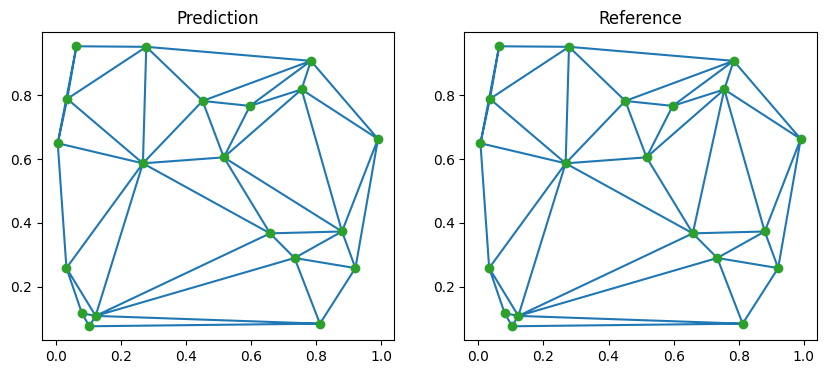

In [10]:
i = 11

test_point = x[i].numpy()
test_tri = indicies[:, i, :].numpy()[(indicies[:, i, :].numpy() != 20).all(axis=1)]

mask = (tri[i].numpy() != 20).all(axis=1) * (tri[i].numpy() != -1).all(axis=1)
reference_tri = tri[i].numpy()[mask]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].triplot(test_point[:,0], test_point[:,1], test_tri)
ax[0].plot(test_point[:,0], test_point[:,1], 'o');
ax[0].set_title("Prediction");

ax[1].triplot(test_point[:,0], test_point[:,1], reference_tri)
ax[1].plot(test_point[:,0], test_point[:,1], 'o');
ax[1].set_title("Reference");

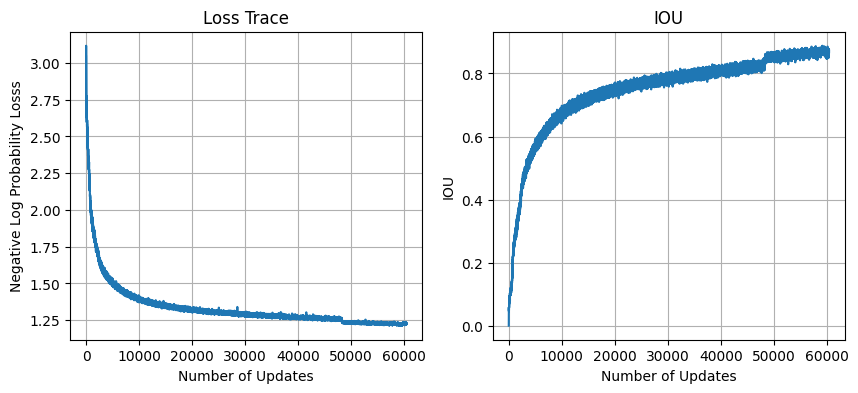

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(loss_trace);
ax[0].grid();
ax[0].set_title("Loss Trace");
ax[0].set_xlabel("Number of Updates");
ax[0].set_ylabel("Negative Log Probability Losss");
ax[1].plot(iou);
ax[1].grid();
ax[1].set_title("IOU");
ax[1].set_xlabel("Number of Updates");
ax[1].set_ylabel("IOU");

In [12]:
##evaluate the model using IOU on train set
iou_list = []
for x, tri in tqdm(train_loader):
    data_batch = make_pyg_batch_wedge(x, 5)
    logits, indicies = model(data_batch, max_steps=50)
    iou_list.append(iou_triangles(tri, indicies))
print("Average IOU w/o teacher forcing: ", sum(iou_list)/len(iou_list))

  0%|          | 0/302 [00:00<?, ?it/s]

Average IOU w/o teacher forcing:  0.7412767655012623


In [14]:
##evaluate the model using IOU on train set
accuracy_list = []
for x, tri in tqdm(train_loader):
    data_batch = make_pyg_batch_wedge(x, 5)
    logits, indicies = model(data_batch, max_steps=50)
    accuracy_list.append(iou_accuracy(tri, indicies))
print("Average accuracy w/o teacher forcing: ", sum(accuracy_list)/len(accuracy_list))

  0%|          | 0/302 [00:00<?, ?it/s]

Average accuracy w/o teacher forcing:  0.8620902455800417


In [15]:
##evaluate the model using IOU on test set
iou_list = []
for x, tri in tqdm(test_loader):
    data_batch = make_pyg_batch_wedge(x, 5)
    logits, indicies = model(data_batch, max_steps=50)
    iou_list.append(iou_triangles(tri, indicies))
print("Average IOU w/o teacher forcing: ", sum(iou_list)/len(iou_list))

  0%|          | 0/20 [00:00<?, ?it/s]

Average IOU w/o teacher forcing:  0.7217896431684494


In [16]:
##evaluate the model using accuracy on test set
accuracy_list = []
for x, tri in tqdm(test_loader):
    data_batch = make_pyg_batch_wedge(x, 5)
    logits, indicies = model(data_batch, max_steps=50)
    accuracy_list.append(iou_accuracy(tri, indicies))
print("Average accuracy w/o teacher forcing: ", sum(accuracy_list)/len(accuracy_list))

  0%|          | 0/20 [00:00<?, ?it/s]

Average accuracy w/o teacher forcing:  0.8522561073303223


NameError: name 'loss_trace' is not defined

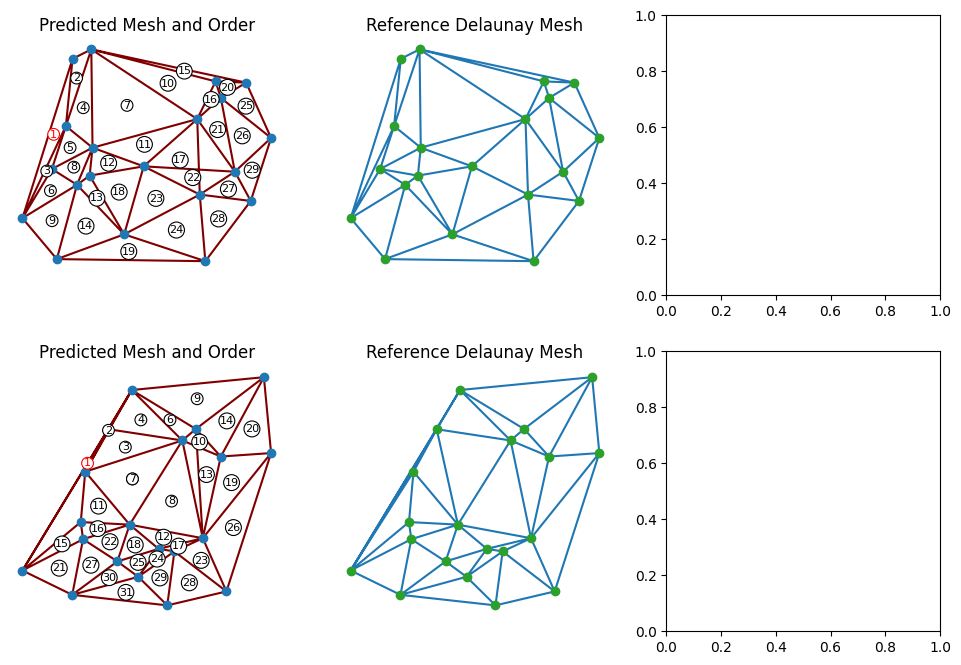

In [11]:
i = 2; j = 28

test_point = x[i].numpy()
test_tri = indicies[:, i, :].numpy()[(indicies[:, i, :].numpy() != 20).all(axis=1)]

mask = (tri[i].numpy() != 20).all(axis=1) * (tri[i].numpy() != -1).all(axis=1)
reference_tri = tri[i].numpy()[mask]

fig, ax = plt.subplots(2, 3, figsize=(12, 8))

ax[0][0].triplot(test_point[:,0], test_point[:,1], test_tri, color='maroon')
ax[0][0].plot(test_point[:,0], test_point[:,1], 'o');
ax[0][0].set_title("Prediction");

ax[0][1].triplot(test_point[:,0], test_point[:,1], reference_tri)
ax[0][1].plot(test_point[:,0], test_point[:,1], 'o');
ax[0][1].set_title("Reference");


tri_indices = test_tri           # (T, 3)
coords      = test_point              # (N, 2)
centroids   = coords[tri_indices].mean(axis=1)

for t_id, (cx, cy) in enumerate(centroids):
    if t_id == 0:
        ax[0][0].text(cx, cy, str(t_id+1), fontsize=8,
               ha="center", va="center", zorder=5, color='red',
               bbox={                      # use literal to avoid shadowed dict()
                   "boxstyle": "circle,pad=0.08",
                   "fc": "white",
                   "ec": "red",
                   "lw": 0.8
               })
    else:
        ax[0][0].text(cx, cy, str(t_id+1), fontsize=8,
                   ha="center", va="center", zorder=5,
                   bbox={                      # use literal to avoid shadowed dict()
                       "boxstyle": "circle,pad=0.08",
                       "fc": "white",
                       "ec": "black",
                       "lw": 0.8
                   })

ax[0][0].set_title("Predicted Mesh and Order");
ax[0][1].set_title("Reference Delaunay Mesh");
ax[0][0].axis("off"); ax[0][1].axis("off");
ax[0][0].set_aspect('equal', adjustable='box');
ax[0][1].set_aspect('equal', adjustable='box');

#============================

test_point = x[j].numpy()
test_tri = indicies[:, j, :].numpy()[(indicies[:, j, :].numpy() != 20).all(axis=1)]

mask = (tri[j].numpy() != 20).all(axis=1) * (tri[j].numpy() != -1).all(axis=1)
reference_tri = tri[j].numpy()[mask]

ax[1][0].triplot(test_point[:,0], test_point[:,1], test_tri, color='maroon')
ax[1][0].plot(test_point[:,0], test_point[:,1], 'o');
ax[1][0].set_title("Prediction");

ax[1][1].triplot(test_point[:,0], test_point[:,1], reference_tri)
ax[1][1].plot(test_point[:,0], test_point[:,1], 'o');
ax[1][1].set_title("Reference");


tri_indices = test_tri           # (T, 3)
coords      = test_point              # (N, 2)
centroids   = coords[tri_indices].mean(axis=1)

for t_id, (cx, cy) in enumerate(centroids):
    if t_id == 0:
        ax[1][0].text(cx, cy, str(t_id+1), fontsize=8,
               ha="center", va="center", zorder=5, color='red',
               bbox={                      # use literal to avoid shadowed dict()
                   "boxstyle": "circle,pad=0.08",
                   "fc": "white",
                   "ec": "red",
                   "lw": 0.8
               })
    else:
        ax[1][0].text(cx, cy, str(t_id+1), fontsize=8,
                   ha="center", va="center", zorder=5,
                   bbox={                      # use literal to avoid shadowed dict()
                       "boxstyle": "circle,pad=0.08",
                       "fc": "white",
                       "ec": "black",
                       "lw": 0.8
                   })

ax[1][0].set_title("Predicted Mesh and Order");
ax[1][1].set_title("Reference Delaunay Mesh");
ax[1][0].axis("off"); ax[1][1].axis("off");
ax[1][0].set_aspect('equal', adjustable='box');
ax[1][1].set_aspect('equal', adjustable='box');

ax[0][2].plot(loss_trace);
ax[0][2].grid();
ax[0][2].set_title("Loss Trace");
ax[0][2].set_ylabel("Negative Log Probability Losss");
ax[1][2].plot(iou);
ax[1][2].grid();
ax[1][2].set_title("IOU");
ax[1][2].set_xlabel("Number of Updates");
ax[1][2].set_ylabel("IOU");

#plt.savefig("Results.png", dpi=600);

In [218]:
#torch.save(model.state_dict(), 'model18.pt')

In [116]:
#test set
data_test = np.load("test_5000_bfs_k5_N15.npz")
X_test = torch.Tensor(data_test["X"]).to(device) #shape N, 15, 2 N = 10000
tri_test = torch.Tensor(data_test["tri"]).to(device)

test_dataset = GraphDataSet_new(X_test, tri_test)
batch_size = 256
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [118]:
for x, tri in test_loader:
    break

data_batch = make_pyg_batch_wedge(x, 5)
logits, indicies = model(data_batch, max_steps=40, N=15)

Encoder output shape:  torch.Size([256, 15, 256])


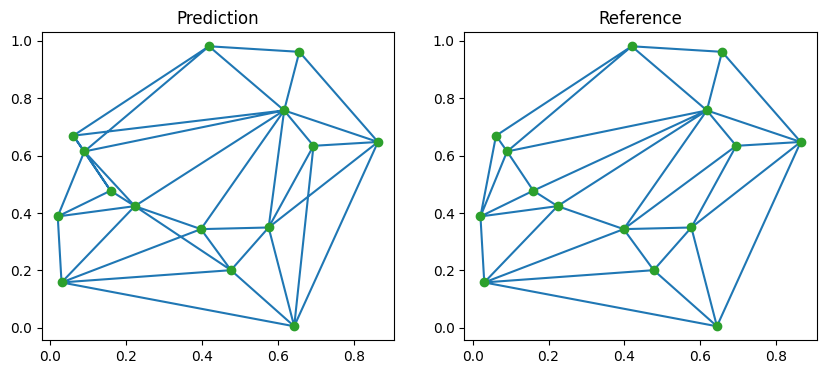

In [127]:
i = 9
end_index = x.shape[1]
test_point = x[i].numpy()
test_tri = indicies[:, i, :].numpy()[(indicies[:, i, :].numpy() != end_index).all(axis=1)]

mask = (tri[i].numpy() != end_index).all(axis=1) * (tri[i].numpy() != -1).all(axis=1)
reference_tri = tri[i].numpy()[mask]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].triplot(test_point[:,0], test_point[:,1], test_tri)
ax[0].plot(test_point[:,0], test_point[:,1], 'o');
ax[0].set_title("Prediction");

ax[1].triplot(test_point[:,0], test_point[:,1], reference_tri)
ax[1].plot(test_point[:,0], test_point[:,1], 'o');
ax[1].set_title("Reference");